In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle

pkl_path =  '/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn/tsne_pretrain_pvrcnn/new.pkl'

# Load data from pickle file
with open(pkl_path, 'rb') as f:
    pretrained_data = pickle.load(f)


In [3]:
pretrained_data.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'obj_scores', 'gt_boxes', 'assigned_gt_inds', 'assigned_iou_class', 'roi_scores', 'num_points_in_roi', 'class_labels', 'iteration', 'shared_features', 'frame_id', 'shared_features_gt'])

In [ ]:
pretrained_data['assigned_iou_class']

New branch (tsne_pretrain_3diou_org) to capture and recreate tSNE plots for pretrained data
Script used to generate ckpt for TsNE listed below:

In [5]:

# {
# 	"version": "0.2.0",
# 	"configurations": [
#     	{
#         	"name": "Run with argument",
#         	"type": "python",
#         	"request": "launch",
#         	"program": "${file}",
#         	"console": "integratedTerminal",
#         	"cwd": "${workspaceFolder}/tools",
#         	"env": {"CUDA_VISIBLE_DEVICES": "2"},
#         	"args": ["--cfg_file" ,
#                 	// "cfgs/kitti_models/pv_rcnn_ssl_60.yaml",
# 					"./cfgs/kitti_models/pv_rcnn.yaml",
#                 	"--split",
#                 	"train_0.01_1",
#                 	"--batch_size",
#                 	"8",
#                 	"--ckpt_save_interval",
#                 	"1",
#                 	"--repeat",
# 					"1",
# 					"--epochs",
# 					"81",
#                 	// "5",
#                 	"--fix_random_seed",
#                 	"--extra_tag",
#                 	"tsne_pretrain_pvrcnn", 
# 					"--ckpt",
# 					"/mnt/data/OpenPCDet_soft-teacher/output/old/cfgs/kitti_models/pv_rcnn/split_0.01_1/ckpt/checkpoint_epoch_80.pth"
#                 	// "--thresh",
# 					// "0.0,0.25,0.25", 
#                 	// "--sem_thresh", 
# 					// "0.0,0.0,0.0", 
#                 	// "--dbinfos",
#                 	// "kitti_dbinfos_train_0.01_1_37.pkl",
#                 	// "--set", 
#                 	// "MODEL.ROI_HEAD.ENABLE_SOFT_TEACHER",
#                 	// "True",
#                 	// "MODEL.ROI_HEAD.ENABLE_VIS",
#                 	// "False",
#                 	// "MODEL.POST_PROCESSING.TEST_EVAL_DURING_TRAIN",
#                 	// "False",
#                 	// "MODEL.ROI_HEAD.ENABLE_EVAL",
#                 	// "True",
#                 	// "MODEL.ROI_HEAD.LOSS_CONFIG.UL_RCNN_CLS_WEIGHT_TYPE",
#                 	// "all",
# 					// "MODEL.ROI_HEAD.ENABLE_RCNN_CONSISTENCY",
# 					// "False"
#         	],
#     	}
# 	]
# }

In [6]:
iou_roi_pl = np.array(pretrained_data['iou_roi_pl'])
iou_roi_gt = np.array(pretrained_data['iou_roi_gt'])

assigned_iou_class = np.array(pretrained_data['assigned_iou_class'])
obj_scores = np.array(pretrained_data['obj_scores'])
class_labels = np.array(pretrained_data['class_labels'])
class_labels = class_labels - 1

fg_mask = iou_roi_gt > 0.25
cc_mask =  assigned_iou_class == class_labels
obj_mask  = obj_scores > 0.25

cc_fg_mask = fg_mask & cc_mask

print('Number of Predicted FGs:{} and BGs:{}'.format(np.sum(obj_mask), np.sum(~obj_mask)))
print('Number of Actual FGs:{} and BGs:{}'.format(np.sum(fg_mask), np.sum(~fg_mask)))
correct_obj_classifications = np.sum(obj_mask & fg_mask)
correct_fg_classifications = np.sum(cc_mask & fg_mask)
correct_bg_classifications = np.sum(~fg_mask & ~obj_mask)

print("Total", len(pretrained_data['assigned_iou_class']))
print("Number of correct object classifications:", correct_obj_classifications)
print("Number of correct background classifications:", correct_bg_classifications)
print("Number of correct semantic classifications:", correct_fg_classifications)
num_true_fg_mask = np.sum(fg_mask)
print("Number of True elements in fg_mask:", num_true_fg_mask)



Number of Predicted FGs:2995 and BGs:1741
Number of Actual FGs:3503 and BGs:1233
Total 4736
Number of correct object classifications: 2923
Number of correct background classifications: 1161
Number of correct semantic classifications: 3460
Number of True elements in fg_mask: 3503


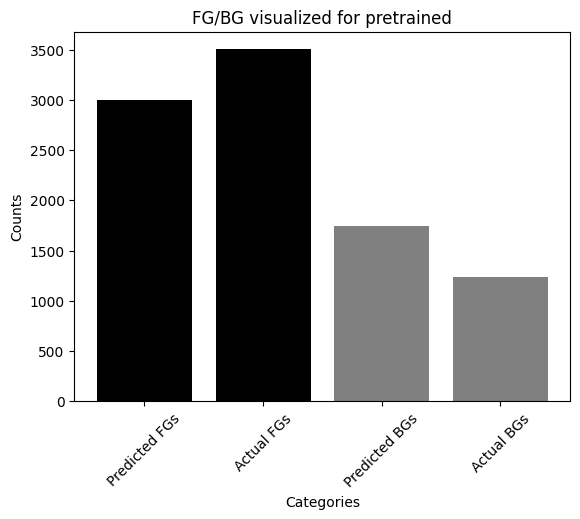

In [33]:

import matplotlib.pyplot as plt

data = {
    'Predicted FGs': 2995,
    'Actual FGs': 3503,
    'Predicted BGs': 1741,
    'Actual BGs': 1233,
}

plt.bar(data.keys(), data.values(), color=['black', 'black', 'gray', 'gray'])
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('FG/BG visualized for pretrained')
plt.xticks(rotation=45)
plt.show()



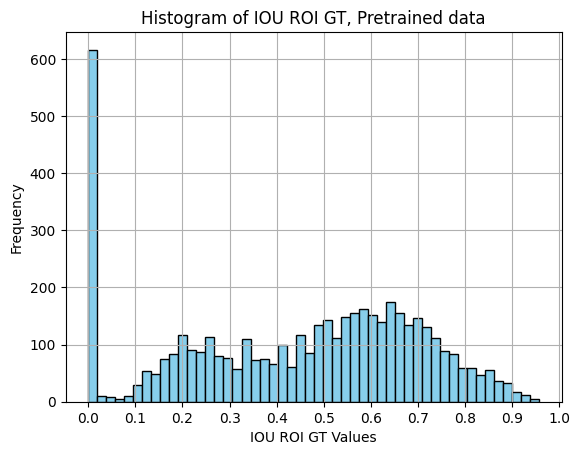

In [24]:
import matplotlib.pyplot as plt
# iou_roi_pl = pretrained_data['iou_roi_pl']
iou_roi_gt = pretrained_data['iou_roi_gt']
# Plot histogram
plt.hist(iou_roi_gt, bins=50, color='skyblue', edgecolor='black')
plt.xticks(np.arange(0, 1.1, step=0.1))  # Set ticks from 0.05 to 1.0 with step 0.05

plt.title('Histogram of IOU ROI GT, Pretrained data')
plt.xlabel('IOU ROI GT Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Above plot shows the IOU Of ROI with GT_Boxes for labeled data (1%, split 1) at the end of pretraining. The assessment has been done on the best pretrained ckpt after 80 epochs. 

IOU_ROI_PL for FG peaks around 0.65-0.7.. The number of ROIs having IOU wrt GT > 70% is quite low. Is this expected?

In [ ]:
shared_features_list = pretrained_data['shared_features']
# Shared_features_list contains data for ROIs
unsqueezed_tensors = [tensor.unsqueeze(0) for tensor in shared_features_list]
ft_sh = torch.cat(unsqueezed_tensors, dim=0)
ft_sh = ft_sh.squeeze()
print(ft_sh.shape) 
roi_classes =  torch.tensor(pretrained_data['class_labels'])
print(roi_classes.shape)

In [ ]:
shared_features_gt_list = pretrained_data['shared_features_gt']
# Shared_features_list contains data for ROIs
unsqueezed_tensors = [tensor.unsqueeze(0) for tensor in shared_features_gt_list]
ft_sh_gt = torch.cat(unsqueezed_tensors, dim=0)
print(ft_sh_gt.shape) 
gt_classes =  torch.tensor(pretrained_data['gt_boxes'])
print(gt_classes.shape)

In [10]:
selected_sh = ft_sh
selected_roi_classes = roi_classes -1 

In [11]:
# num_classes = 3
# classwise_metrics = {}
# for metric_name in self.metrics_name:
#     classwise_metrics[metric_name] = sample_tensor.new_zeros(num_classes + 1).fill_(float('nan'))

# for cind in range(num_classes):
#     pred_cls_mask = pred_labels == cind
#     gt_cls_mask = valid_gt_boxes[:, -1] == cind
#     classwise_metrics['num_pred_boxes'][cind] = pred_cls_mask.sum()
#     classwise_metrics['num_gt_boxes'][cind] = gt_cls_mask.sum()


#     if num_gts > 0 and num_preds > 0:
#         overlap = iou3d_nms_utils.boxes_iou3d_gpu(valid_pred_boxes[:, 0:7], valid_gt_boxes[:, 0:7])
#         preds_iou_max, assigned_gt_inds = overlap.max(dim=1)

#         assigned_gt_cls_mask = valid_gt_boxes[assigned_gt_inds, -1] == cind

#         cc_mask = (pred_cls_mask & assigned_gt_cls_mask)  # correctly classified mask
#         mc_mask = (pred_cls_mask & (~assigned_gt_cls_mask)) | ((~pred_cls_mask) & assigned_gt_cls_mask)  # misclassified mask

#         fg_mask = preds_iou_max >= classwise_fg_thresh
#         bg_mask = preds_iou_max <= self.config.ROI_HEAD.TARGET_CONFIG.CLS_BG_THRESH

#         cc_fg_mask = fg_mask & cc_mask
#         classwise_metrics['pred_fgs'][cind] = (cc_fg_mask).sum() / cc_mask.sum()
#         classwise_metrics['pred_ious'][cind] = (preds_iou_max * cc_fg_mask.float()).sum() / cc_fg_mask.sum()
#         cls_score_fg = (valid_pred_scores * cc_fg_mask.float()).sum() / (cc_fg_mask).sum()
#         classwise_metrics['score_fgs'][cind] = cls_score_fg

#         cls_bg_mask = pred_cls_mask & bg_mask
#         classwise_metrics['pred_ious_bgs'][cind] = (preds_iou_max * cls_bg_mask.float()).sum() / cls_bg_mask.sum()
#         cls_score_bg = (valid_pred_scores * cls_bg_mask.float()).sum() / torch.clamp(bg_mask.float().sum(), min=1.0)
#         classwise_metrics['score_bgs'][cind] = cls_score_bg


#         if valid_pred_iou_wrt_pl is not None:
#             fg_threshs = self.config.ROI_HEAD.TARGET_CONFIG.CLS_FG_THRESH
#             bg_thresh = self.config.ROI_HEAD.TARGET_CONFIG.CLS_BG_THRESH
#             classwise_fg_thresh = fg_threshs[cind]

#             fn_mask = (cls_bg_mask_wrt_pl | cls_uc_mask_wrt_pl) & cc_fg_mask
#             tp_mask = cls_fg_mask_wrt_pl & cc_fg_mask
#             fp_mask = cls_fg_mask_wrt_pl & (cls_bg_mask | cc_uc_mask)

#             fg_mask_wrt_pl = valid_pred_iou_wrt_pl >= classwise_fg_thresh
#             bg_mask_wrt_pl = valid_pred_iou_wrt_pl <= bg_thresh

In [ ]:
frame_array = np.array(pretrained_data['frame_id'])
repeated_frame_array = np.repeat(frame_array, 128)
len(repeated_frame_array)

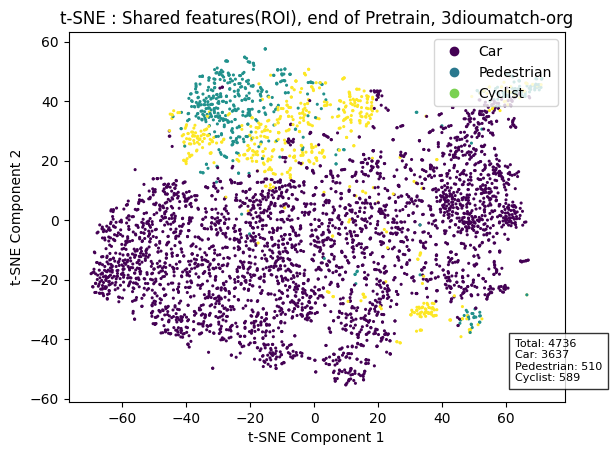

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

obj_scores = pretrained_data['obj_scores']

# Create a sample dataset
x = selected_sh.cpu().numpy()
y = selected_roi_classes.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE : Shared features(ROI), end of Pretrain, 3dioumatch-org')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=len(class_names))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()


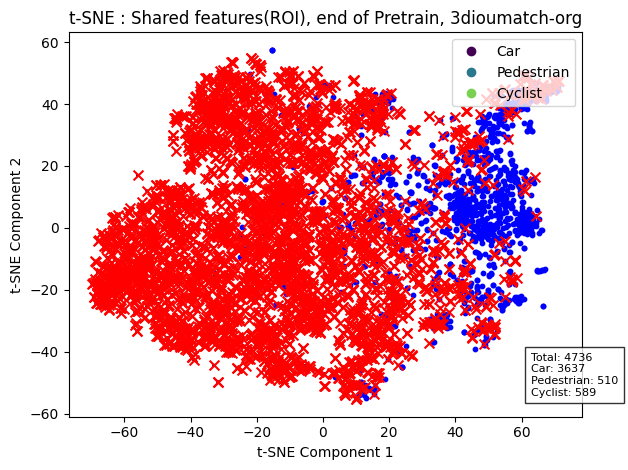

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh.cpu().numpy()
y = selected_roi_classes.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)


# Create figure and subplots
fig, ax = plt.subplots()
# Plot t-SNE features
scatter = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('t-SNE : Shared features(ROI), end of Pretrain, 3dioumatch-org')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=len(class_names))
legend = ax.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
ax.text(0.9, 0.05, occurrences_text, transform=ax.transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

unmasked_indices = np.where(~fg_mask)[0]
masked_indices = np.where(fg_mask)[0]

ax.scatter(x_tsne[unmasked_indices, 0], x_tsne[unmasked_indices, 1], c='blue', s=10, marker='o', label='Unmasked')
ax.scatter(x_tsne[masked_indices, 0], x_tsne[masked_indices, 1], c='red', s=50, marker='x', label='Masked')

plt.tight_layout()
plt.show()


/tmp/ipykernel_32748/3861746581.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter2 = axs[1].scatter(x_tsne[:, 0], x_tsne[:, 1], c='grey', cmap='Greys', s=1.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_32748/3861746581.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter3 = axs[2].scatter(x_tsne[:, 0], x_tsne[:, 1], c='grey', cmap='Greys', s=2.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


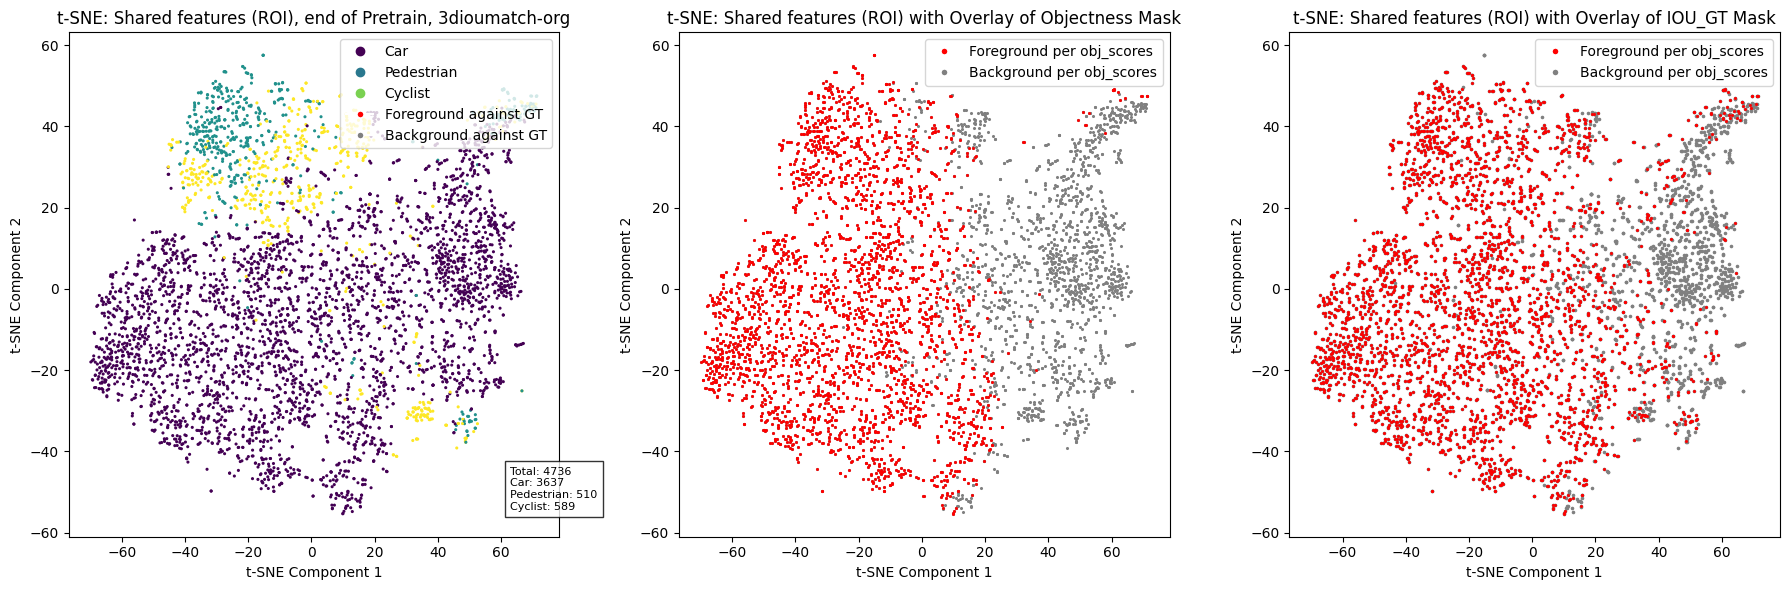

In [15]:
# Create figure and axis object for subplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first t-SNE plot with colored points based on labels
scatter1 = axs[0].scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
axs[0].set_xlabel('t-SNE Component 1')
axs[0].set_ylabel('t-SNE Component 2')
axs[0].set_title('t-SNE: Shared features (ROI), end of Pretrain, 3dioumatch-org')

# Add legend to the first subplot
handles1, _ = scatter1.legend_elements(num=len(class_names))
legend1 = axs[0].legend(handles1, class_names, loc='upper right')

axs[0].text(0.9, 0.05, occurrences_text, transform=axs[0].transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# Update legend labels for the first subplot
legend_labels = ['Car', 'Pedestrian', 'Cyclist', 'Foreground against GT', 'Background against GT']
legend_handles = handles1 + [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5),
                            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=5)]
legend1 = axs[0].legend(legend_handles, legend_labels, loc='upper right')

scatter2 = axs[1].scatter(x_tsne[:, 0], x_tsne[:, 1], c='grey', cmap='Greys', s=1.5)
axs[1].scatter(x_tsne[obj_mask, 0], x_tsne[obj_mask, 1], color='red', s=1.5, alpha=0.9)  # Overlay of obj_mask
axs[1].set_xlabel('t-SNE Component 1')
axs[1].set_ylabel('t-SNE Component 2')
axs[1].set_title('t-SNE: Shared features (ROI) with Overlay of Objectness Mask')

axs[1].legend().set_visible(True)
axs[1].text(0.9, 0.05, "", transform=axs[1].transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5),
                            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=5)]
legend_labels = ['Foreground per obj_scores', 'Background per obj_scores']
legend2 = axs[1].legend(legend_handles, legend_labels, loc='upper right')

scatter3 = axs[2].scatter(x_tsne[:, 0], x_tsne[:, 1], c='grey', cmap='Greys', s=2.5)
axs[2].scatter(x_tsne[fg_mask, 0], x_tsne[fg_mask, 1], color='red', s=1.5, alpha=0.9)  # Overlay of obj_mask
axs[2].set_xlabel('t-SNE Component 1')
axs[2].set_ylabel('t-SNE Component 2')
axs[2].set_title('t-SNE: Shared features (ROI) with Overlay of IOU_GT Mask')

axs[2].legend().set_visible(True)
legend3 = axs[2].legend(legend_handles, legend_labels, loc='upper right')


plt.tight_layout()
plt.show()
 

/tmp/ipykernel_32748/1868790130.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter2 = axs[1].scatter(x_tsne[:, 0], x_tsne[:, 1], c='grey', cmap='Greys', s=1.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


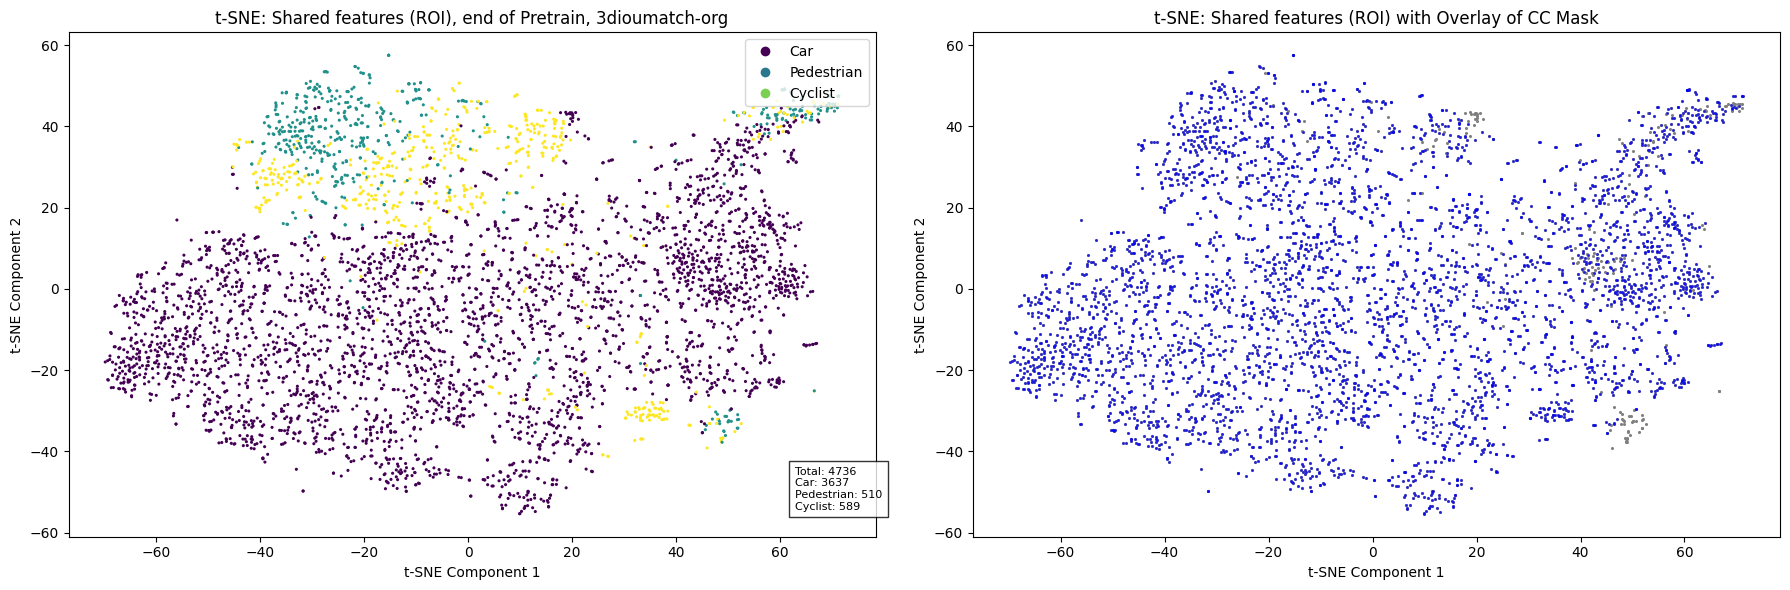

In [16]:
# Create figure and axis object for subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first t-SNE plot with colored points based on labels
scatter1 = axs[0].scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
axs[0].set_xlabel('t-SNE Component 1')
axs[0].set_ylabel('t-SNE Component 2')
axs[0].set_title('t-SNE: Shared features (ROI), end of Pretrain, 3dioumatch-org')

# Add legend to the first subplot
handles1, _ = scatter1.legend_elements(num=len(class_names))
legend1 = axs[0].legend(handles1, class_names, loc='upper right')

# Add a box showing occurrences of each class in the first subplot
axs[0].text(0.9, 0.05, occurrences_text, transform=axs[0].transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# Plot the second t-SNE plot with overlay of cc_mask
scatter2 = axs[1].scatter(x_tsne[:, 0], x_tsne[:, 1], c='grey', cmap='Greys', s=1.5)
axs[1].scatter(x_tsne[cc_mask, 0], x_tsne[cc_mask, 1], color='blue', s=1.5, alpha=0.5)  # Overlay of obj_mask
axs[1].set_xlabel('t-SNE Component 1')
axs[1].set_ylabel('t-SNE Component 2')
axs[1].set_title('t-SNE: Shared features (ROI) with Overlay of CC Mask')

# Hide legend and occurrences box for the second subplot
axs[1].legend().set_visible(False)
axs[1].text(0.9, 0.05, "", transform=axs[1].transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# # Plot the second t-SNE plot with overlay of cc_fg_mask
# scatter3 = axs[2].scatter(x_tsne[:, 0], x_tsne[:, 1], c='grey', cmap='Greys', s=2.5)
# axs[2].scatter(x_tsne[cc_fg_mask, 0], x_tsne[cc_fg_mask, 1], color='blue', s=2.5, alpha=0.6)  # Overlay of obj_mask
# axs[2].set_xlabel('t-SNE Component 1')
# axs[2].set_ylabel('t-SNE Component 2')
# axs[2].set_title('t-SNE: Shared features (ROI) with Overlay of CC_FG Mask')

# # Hide legend and occurrences box for the second subplot
# axs[2].legend().set_visible(False)
# axs[2].text(0.9, 0.05, "", transform=axs[1].transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# Set the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

obj_scores = pretrained_data['obj_scores']

# 
x_pred_fg = selected_sh[obj_mask].cpu().numpy()
y_pred_fg = selected_roi_classes[obj_mask].cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x_pred_fg)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_pred_fg, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE : Shared features(ROI), Predicted FG features, end of Pretrain, 3dioumatch-org')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=len(class_names))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y_pred_fg)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

obj_scores = pretrained_data['obj_scores']

# 
x_actual_fg = selected_sh[fg_mask].cpu().numpy()
y_actual_fg = selected_roi_classes[fg_mask].cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x_actual_fg)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_actual_fg, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE : Shared features(ROI), Predicted FG features, end of Pretrain, 3dioumatch-org')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=len(class_names))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y_actual_fg)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()


In [19]:
selected_sh_gt = ft_sh_gt
selected_gt_classes = gt_classes[:,-1]

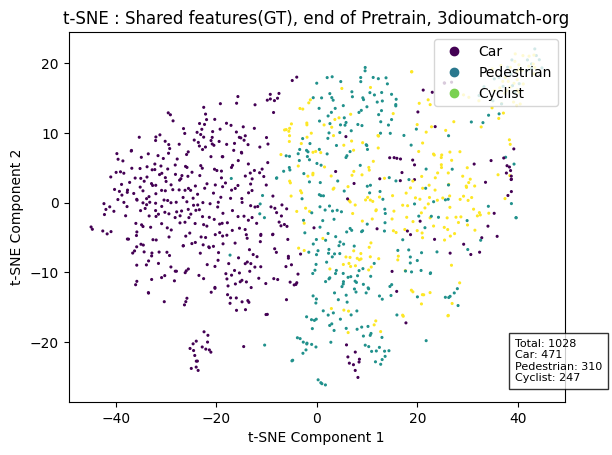

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh_gt.cpu().numpy()
y = selected_gt_classes.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE : Shared features(GT), end of Pretrain, 3dioumatch-org')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=len(class_names))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()


In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle

pkl_path =  '/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn/tsne_pretrain_pvrcnn/new_ohnegtsmpl.pkl'

# Load data from pickle file
with open(pkl_path, 'rb') as f:
    pretrained_data_new = pickle.load(f)


In [3]:
pretrained_data_new.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'obj_scores', 'gt_boxes', 'assigned_gt_inds', 'assigned_iou_class', 'roi_scores', 'num_points_in_roi', 'class_labels', 'iteration', 'shared_features', 'frame_id', 'shared_features_gt'])

In [4]:
iou_roi_pl = np.array(pretrained_data_new['iou_roi_pl'])
iou_roi_gt = np.array(pretrained_data_new['iou_roi_gt'])

assigned_iou_class = np.array(pretrained_data_new['assigned_iou_class'])
obj_scores = np.array(pretrained_data_new['obj_scores'])
class_labels = np.array(pretrained_data_new['class_labels'])
class_labels = class_labels - 1

fg_mask = iou_roi_gt > 0.25
cc_mask =  assigned_iou_class == class_labels
obj_mask  = obj_scores > 0.25

cc_fg_mask = fg_mask & cc_mask

print('Number of Predicted FGs:{} and BGs:{}'.format(np.sum(obj_mask), np.sum(~obj_mask)))
print('Number of Actual FGs:{} and BGs:{}'.format(np.sum(fg_mask), np.sum(~fg_mask)))
correct_obj_classifications = np.sum(obj_mask & fg_mask)
correct_fg_classifications = np.sum(cc_mask & fg_mask)
correct_bg_classifications = np.sum(~fg_mask & ~obj_mask)

print("Total", len(pretrained_data['assigned_iou_class']))
print("Number of correct object classifications:", correct_obj_classifications)
print("Number of correct background classifications:", correct_bg_classifications)
print("Number of correct semantic classifications:", correct_fg_classifications)
num_true_fg_mask = np.sum(fg_mask)
print("Number of True elements in fg_mask:", num_true_fg_mask)



Number of Predicted FGs:2916 and BGs:1820
Number of Actual FGs:1227 and BGs:3509


NameError: name 'pretrained_data' is not defined

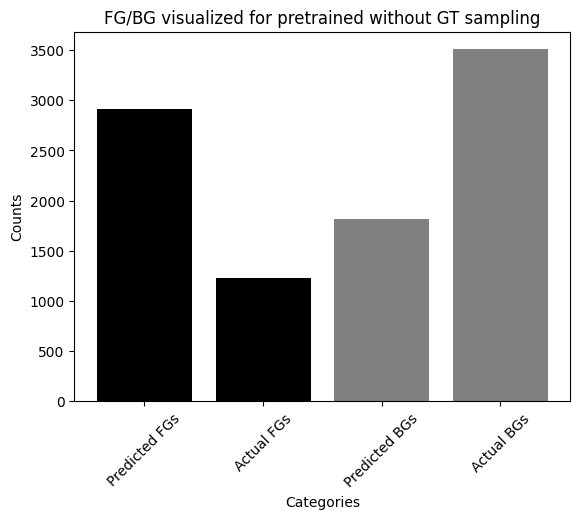

In [ ]:

import matplotlib.pyplot as plt

data = {
    'Predicted FGs': 2916,
    'Actual FGs': 1227,
    'Predicted BGs': 1820,
    'Actual BGs': 3509,
}

plt.bar(data.keys(), data.values(), color=['black', 'black', 'gray', 'gray'])
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('FG/BG visualized for pretrained without GT sampling')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
# iou_roi_pl = pretrained_data['iou_roi_pl']
iou_roi_gt = pretrained_data_new['iou_roi_gt']
# Plot histogram
plt.hist(iou_roi_gt, bins=50, color='skyblue', edgecolor='black')
plt.xticks(np.arange(0, 1.1, step=0.1))  # Set ticks from 0.05 to 1.0 with step 0.05

plt.title('Histogram of IOU ROI GT, Pretrained data')
plt.xlabel('IOU ROI GT Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
shared_features_gt_list = pretrained_data_new['shared_features_gt']
# Shared_features_list contains data for ROIs
unsqueezed_tensors = [tensor.unsqueeze(0) for tensor in shared_features_gt_list]
ft_sh_gt = torch.cat(unsqueezed_tensors, dim=0)
print(ft_sh_gt.shape) 
gt_classes =  torch.tensor(pretrained_data_new['gt_boxes'])
print(gt_classes.shape)

torch.Size([208, 256])
torch.Size([208, 8])


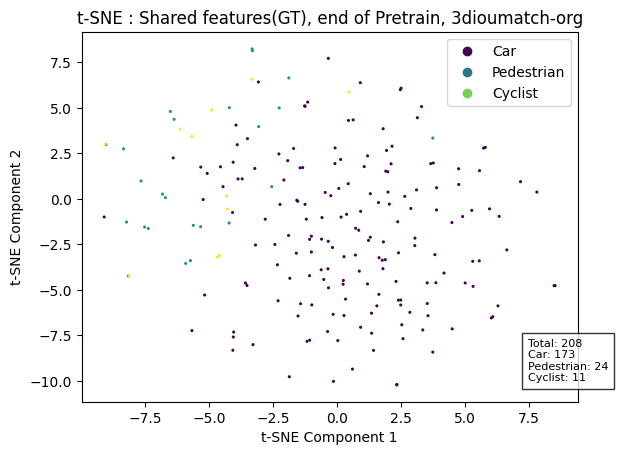

In [11]:
selected_sh_gt = ft_sh_gt
selected_gt_classes = gt_classes[:,-1]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh_gt.cpu().numpy()
y = selected_gt_classes.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE : Shared features(GT), end of Pretrain, 3dioumatch-org')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=len(class_names))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

